## IMERG `Patchify`

* The aim of this notebook is to patchify a raw IMERG tile.

* It tests if the patching done in the data prep pipeline matches a patch done from 1st principles.

* you can use this notebook to identify what regions your grid boxes cover.

In [2]:
import os
import h5py
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
from scipy import io
import cartopy.crs as ccrs
import imageio
from pathlib import Path

from rainnow.src.configs.config import (
    IMERG_CROP,
    PATCH_SIZE,
    IMERG_PIXEL_RES,
)

from rainnow.src.utilities.utils import calculate_required_1d_padding
from rainnow.src.data_prep.data_processing import (
    load_imerg_h5_file_into_xarr,
    crop_xarr_using_lat_and_lon,
    patch_2d_arr_into_nxn_squares,
    open_file_with_h5py_and_get_data,
)
from rainnow.src.plotting import (
    plot_raw_imerg_xarray_tile,
    plot_single_patched_imerg_grid,
    geoplot_raw_imerg_xarray_tile,
    add_patch_to_plot,
    add_patch_to_geoplot,
)

#### Plot the a patched IMERG tile in a grid:
* read in a single patched IMERG tile and plot the patches in a grid formation to recreate the actual tile.

##### `Plotting Kwarg Helpers`

In [ ]:
# ** dir helpers **
BASE_PATH = "/teamspace/studios/this_studio"

# load in custom colour map.
cmap = io.loadmat(f"{BASE_PATH}/DYffcast/rainnow/src/utilities/cmaps/colormap.mat")
# cmap = io.loadmat("../../src/utilities/cmaps/colormap.mat")
rain_cmap = ListedColormap(cmap["Cmap_rain"])
plot_params = {"cmap": rain_cmap, "vmin": 0.1, "vmax": 10}
cbar_params = {"orientation": "horizontal", "pad": 0.05, "fraction": 0.01, "aspect": 60}
global_params = {
    "font.size": 10,
    # "font.family": "Times New Roman"
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
}
box_params = {"color": "red", "linestyle": "--", "linewidth": 1}

#### `create a .gif for a chosen period of days`

In [4]:
days = [
    # "2023/03/07",  # cyclone YAKU (peru and ecuador).
    "2023/03/08",
    "2023/03/09",
    # "2023/03/10",
]
file_paths = []
for day in days:
    for fp in os.listdir(f"/Volumes/external_disk_seal/data/GPM/NRT/IMERG/IMERG-ER/{day}/"):
        if fp.split(".")[-1] == "RT-H5":
            file_paths.append(f"/Volumes/external_disk_seal/data/GPM/NRT/IMERG/IMERG-ER/{day}/{fp}")

# create a directory to save the frames.
frames_dir = "frames"
os.makedirs(frames_dir, exist_ok=True)

for idx, file_path in enumerate(file_paths):
    imerg_tile = load_imerg_h5_file_into_xarr(file_path=file_path)
    imerg_tile = crop_xarr_using_lat_and_lon(
        xarr=imerg_tile,
        lat_lims=IMERG_CROP["inner"]["latitude"],
        lon_lims=IMERG_CROP["inner"]["longitude"],
    )

    fig, ax = plot_raw_imerg_xarray_tile(
        imerg_tile=np.flipud(imerg_tile),
        plot_params=plot_params,
        cbar_params=None,
        global_params=global_params,
        figsize=(6, 6),
    )
    ax.axis("off")
    ax.set_title(file_path.split("/")[-1].split(".")[-4])

    # add grid boxes.
    for nx, ny in [(0, 0), (0, 1), (0, 2), (1, 2)]:
        add_patch_to_plot(ax=ax, patch_size=PATCH_SIZE, nx=nx, ny=ny, box_params=box_params)

    frame_path = os.path.join(frames_dir, f"frame_{idx:03d}.png")
    plt.savefig(frame_path, bbox_inches="tight", pad_inches=0)
    plt.close(fig)

# create gif from frames.
frames = []
for idx in range(len(file_paths)):
    frame_path = os.path.join(frames_dir, f"frame_{idx:03d}.png")
    frames.append(imageio.imread(frame_path))

gif_path = "imerg_sequence_with_gridboxes.gif"
imageio.mimsave(gif_path, frames, duration=0.5)

/var/folders/1k/vm_h9ycj6d9020w63h786g5w0000gp/T/ipykernel_43336/1261118695.py:47: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames.append(imageio.imread(frame_path))


/var/folders/1k/vm_h9ycj6d9020w63h786g5w0000gp/T/ipykernel_43336/208719870.py:50: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames.append(imageio.imread(frame_path))


### `INNER CROP` Plot

In [4]:
# # 24th file (counting from 0) in 27th September 2022. (Hurricane Ian).
# fn = "../data/imerg/V07/2022/09/27/imerg/3B-HHR.MS.MRG.3IMERG.20220927-S200000-E202959.1200.V07B.HDF5"

# 48th file (counting from 0) in 24th Jan 2020. (Subtropical Storm Kurimi).
# fn = "../../data/imerg/V07/2020/01/24/3B-HHR-E.MS.MRG.3IMERG.20200124-S233000-E235959.1410.V07B.RT-H5"

# cyclone YUKA
# chosen visual case study --> effects Ecuador, Peru and North-Western
# fn = "/Volumes/external_disk_seal/data/GPM/NRT/IMERG/IMERG-ER/2023/03/07/3B-HHR-E.MS.MRG.3IMERG.20230307-S230000-E232959.1380.V07B.RT-H5"
# fn = "/Volumes/external_disk_seal/data/GPM/NRT/IMERG/IMERG-ER/2023/03/09/3B-HHR-E.MS.MRG.3IMERG.20230309-S120000-E122959.0720.V07B.RT-H5"
# fn = "/Volumes/external_disk_seal/data/GPM/NRT/IMERG/IMERG-ER/2023/03/09/3B-HHR-E.MS.MRG.3IMERG.20230309-S140000-E142959.0840.V07B.RT-H5"
fn = "/Volumes/external_disk_seal/data/GPM/NRT/IMERG/IMERG-ER/2023/03/09/3B-HHR-E.MS.MRG.3IMERG.20230309-S030000-E032959.0180.V07B.RT-H5"

In [5]:
imerg_tile = load_imerg_h5_file_into_xarr(file_path=fn)
imerg_tile = crop_xarr_using_lat_and_lon(
    xarr=imerg_tile,
    lat_lims=IMERG_CROP["inner"]["latitude"],
    lon_lims=IMERG_CROP["inner"]["longitude"],
)
print(imerg_tile.shape)

(768, 512)


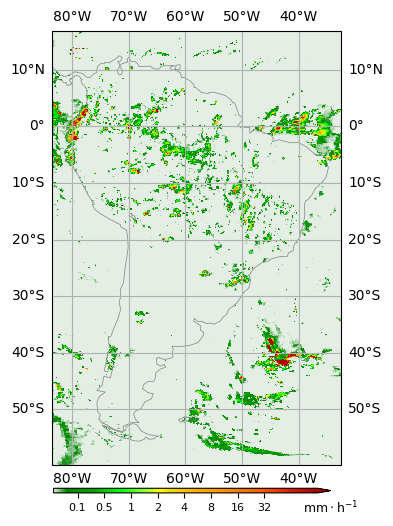

In [6]:
# geoplot: plot the raw imerg tile but with geo features.
fig, ax = geoplot_raw_imerg_xarray_tile(
    imerg_tile=imerg_tile,
    projection=ccrs.PlateCarree(),
    plot_params=plot_params,
    cbar_params={
        "orientation": "horizontal",
        "pad": 0.05,
        "fraction": 0.01,
        "aspect": 60,
        "extend": "max",
    },
    global_params=global_params,
    figsize=(6, 6),
)

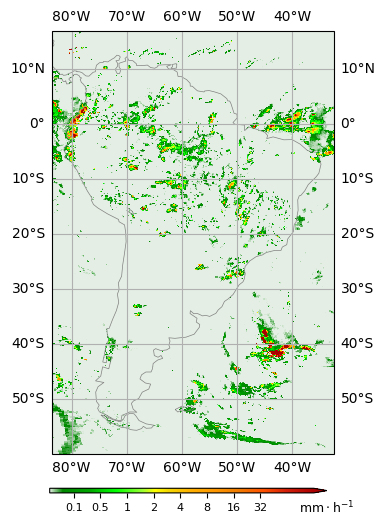

In [7]:
# geoplot: plot the raw imerg tile but with geo features.
fig, ax = geoplot_raw_imerg_xarray_tile(
    imerg_tile=imerg_tile,
    projection=ccrs.PlateCarree(),
    plot_params=plot_params,
    cbar_params={
        "orientation": "horizontal",
        "pad": 0.075,
        "fraction": 0.01,
        "aspect": 60,
        "extend": "max",
    },
    global_params=global_params,
    figsize=(6, 6),
)

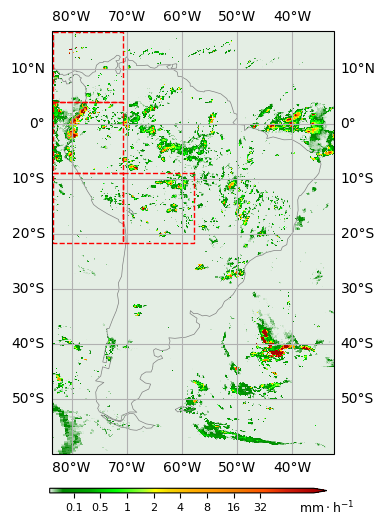

In [8]:
for nx, ny in [(0, 0), (0, 1), (0, 2), (1, 2)]:
    add_patch_to_geoplot(
        ax,
        patch_size=PATCH_SIZE,
        lat_pixel_resolution=IMERG_PIXEL_RES,
        lon_pixel_resolution=IMERG_PIXEL_RES,
        top_left_lon_lat=(
            IMERG_CROP["inner"]["longitude"][0],
            IMERG_CROP["inner"]["latitude"][-1],
        ),  # (longitude, latitude)
        nx=nx + 0.01,
        ny=ny + 0.01,
        box_params=box_params,
    )
fig

In [9]:
# patch the tile.
x_pad = calculate_required_1d_padding(X=imerg_tile.shape[1], Y=PATCH_SIZE, frac=0)
y_pad = calculate_required_1d_padding(X=imerg_tile.shape[0], Y=PATCH_SIZE, frac=0)

print(x_pad, y_pad, imerg_tile.shape)

imerg_patches = patch_2d_arr_into_nxn_squares(
    arr2d=imerg_tile,
    n=PATCH_SIZE,
    x_pad=x_pad,
    y_pad=y_pad,
    flip_pixels=True,
    overlap=0,
)
imerg_patches.shape

0 0 (768, 512)


(6, 4, 128, 128)

(np.float64(-0.5), np.float64(511.5), np.float64(767.5), np.float64(-0.5))

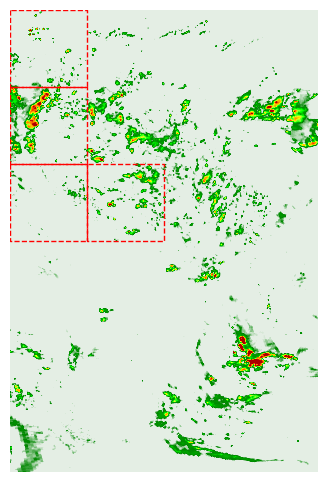

In [10]:
# plot the raw imerg tile but with geo features.
fig, ax = plot_raw_imerg_xarray_tile(
    imerg_tile=np.flipud(imerg_tile),
    plot_params=plot_params,
    cbar_params=None,
    global_params=global_params,
    figsize=(6, 6),
)

for nx, ny in [(0, 0), (0, 1), (0, 2), (1, 2)]:
    add_patch_to_plot(ax=ax, patch_size=PATCH_SIZE, nx=nx, ny=ny, box_params=box_params)

ax.axis("off")

(np.float64(-0.5), np.float64(537.625), np.float64(806.425), np.float64(-0.5))

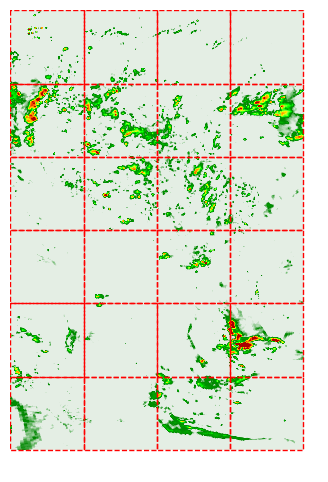

In [11]:
# plot raw image and add the boxes. ALL BOXES.
fig, ax = plot_raw_imerg_xarray_tile(
    imerg_tile=np.flipud(imerg_tile),
    plot_params=plot_params,
    cbar_params=None,
    global_params=global_params,
    figsize=(6, 6),
)

coordinates = [
    (0, 0),
    (1, 0),
    (0, 1),
    (1, 1),
    (0, 2),
    (1, 2),
    (0, 3),
    (1, 3),
    (0, 4),
    (1, 4),
    (0, 5),
    (1, 5),
    (2, 0),
    (3, 0),
    (2, 1),
    (3, 1),
    (2, 2),
    (3, 2),
    (2, 3),
    (3, 3),
    (2, 4),
    (3, 4),
    (2, 5),
    (3, 5),
]
for nx, ny in coordinates:
    add_patch_to_plot(ax=ax, patch_size=PATCH_SIZE, nx=nx, ny=ny, box_params=box_params)

ax.axis("off")

### `OUTER CROP` Plot

(896, 640)


(np.float64(-0.5), np.float64(639.5), np.float64(895.5), np.float64(-0.5))

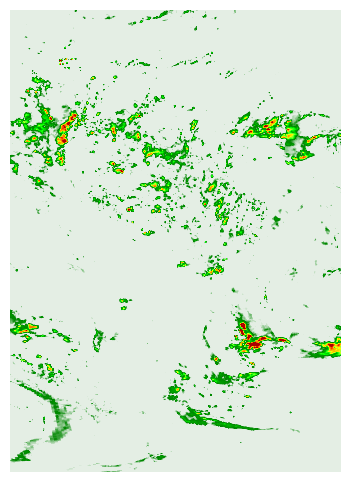

In [12]:
imerg_tile = load_imerg_h5_file_into_xarr(file_path=fn)

lat_lims = IMERG_CROP["outer"]["latitude"]
lon_lims = IMERG_CROP["outer"]["longitude"]
imerg_tile = crop_xarr_using_lat_and_lon(xarr=imerg_tile, lat_lims=lat_lims, lon_lims=lon_lims)
print(imerg_tile.shape)

# plot the raw imerg tile but with geo features.
fig, ax = plot_raw_imerg_xarray_tile(
    imerg_tile=np.flipud(imerg_tile),
    plot_params=plot_params,
    cbar_params=None,
    global_params=global_params,
    figsize=(6, 6),
)

ax.axis("off")

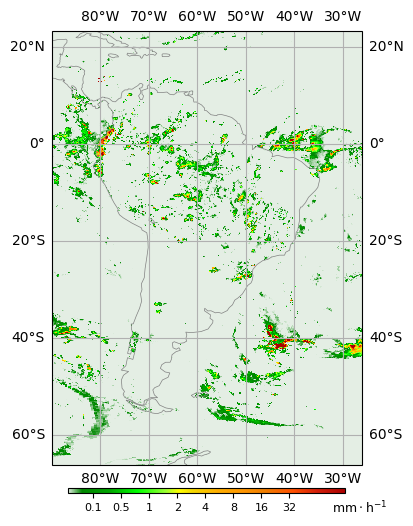

In [13]:
# geoplot - plot the raw imerg tile but with geo features.
fig, ax = geoplot_raw_imerg_xarray_tile(
    imerg_tile=imerg_tile,
    projection=ccrs.PlateCarree(),
    plot_params=plot_params,
    cbar_params={
        "orientation": "horizontal",
        "pad": 0.05,
        "fraction": 0.01,
        "aspect": 60,
    },
    global_params=global_params,
    figsize=(6, 6),
)

### `PATCHING with NO overlap (INNER CROP)`

In [14]:
imerg_tile = load_imerg_h5_file_into_xarr(file_path=fn)
imerg_tile = crop_xarr_using_lat_and_lon(
    xarr=imerg_tile,
    lat_lims=IMERG_CROP["inner"]["latitude"],
    lon_lims=IMERG_CROP["inner"]["longitude"],
)
print(imerg_tile.shape)

(768, 512)


In [15]:
# patch the tile.
x_pad = calculate_required_1d_padding(X=imerg_tile.shape[1], Y=PATCH_SIZE, frac=0)
y_pad = calculate_required_1d_padding(X=imerg_tile.shape[0], Y=PATCH_SIZE, frac=0)
print(x_pad, y_pad, imerg_tile.shape)

imerg_patches = patch_2d_arr_into_nxn_squares(
    arr2d=imerg_tile,
    n=PATCH_SIZE,
    x_pad=x_pad,
    y_pad=y_pad,
    flip_pixels=True,
    overlap=0,
)

imerg_patches.shape

0 0 (768, 512)


(6, 4, 128, 128)

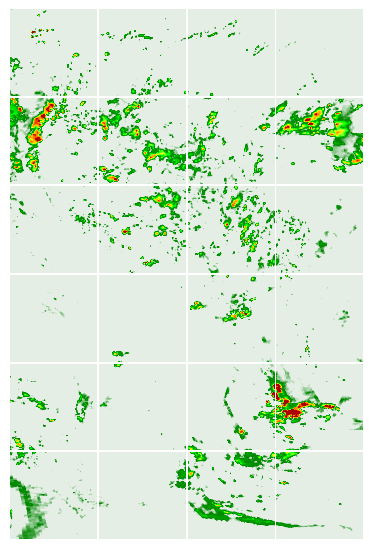

In [16]:
plot_single_patched_imerg_grid(
    patched_imerg_tile=imerg_patches,
    plot_params=plot_params,
    figsize=(3.83, 5.6),
)

In [17]:
print(
    f"** IMERG TILE:  dims = {imerg_tile.shape} w/ latitudes: {imerg_tile.latitude.values.min()}, {imerg_tile.latitude.values.max()}, longitudes: {imerg_tile.longitude.values.min()}, {imerg_tile.longitude.values.max()} **"
)

** IMERG TILE:  dims = (768, 512) w/ latitudes: -59.849998474121094, 16.850000381469727, longitudes: -83.54999542236328, -32.45000076293945 **


### `PATCHING with 50% overlap - with OUTER CROP.`

(896, 640)


(np.float64(-0.5), np.float64(639.5), np.float64(895.5), np.float64(-0.5))

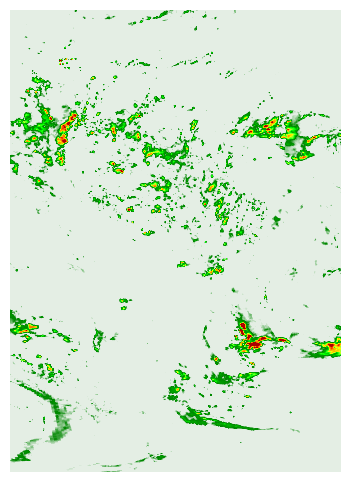

In [18]:
imerg_tile = load_imerg_h5_file_into_xarr(file_path=fn)
imerg_tile = crop_xarr_using_lat_and_lon(
    xarr=imerg_tile,
    lat_lims=IMERG_CROP["outer"]["latitude"],
    lon_lims=IMERG_CROP["outer"]["longitude"],
)
print(imerg_tile.shape)

# plot the raw imerg tile but with geo features.
fig, ax = plot_raw_imerg_xarray_tile(
    imerg_tile=np.flipud(imerg_tile),
    plot_params=plot_params,
    cbar_params=None,
    global_params=global_params,
    figsize=(6, 6),
)

ax.axis("off")

In [19]:
# patch the tile.
x_pad = calculate_required_1d_padding(X=imerg_tile.shape[1], Y=PATCH_SIZE, frac=2)
y_pad = calculate_required_1d_padding(X=imerg_tile.shape[0], Y=PATCH_SIZE, frac=2)
print(x_pad, y_pad)

imerg_patches = patch_2d_arr_into_nxn_squares(
    arr2d=imerg_tile,
    n=PATCH_SIZE,
    x_pad=x_pad,
    y_pad=y_pad,
    flip_pixels=True,
    overlap=0.5,
)

imerg_patches.shape

0 0


(13, 9, 128, 128)

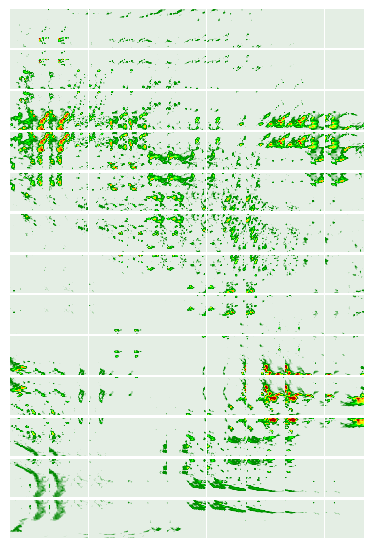

In [20]:
plot_single_patched_imerg_grid(
    patched_imerg_tile=imerg_patches,
    plot_params=plot_params,
    figsize=(3.83, 5.6),
)

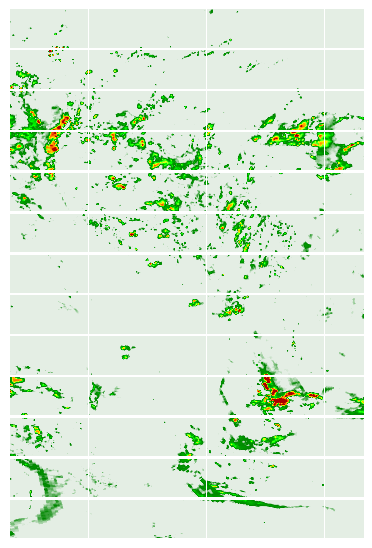

In [21]:
# if I plot the inner nxn pixels, I get the inner crop.
indim = 32
plot_single_patched_imerg_grid(
    patched_imerg_tile=imerg_patches[:, :, indim:-indim, indim:-indim],
    plot_params=plot_params,
    figsize=(3.83, 5.6),
)

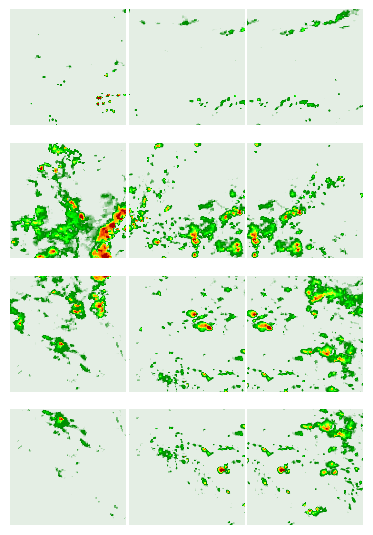

In [22]:
# avoiding plotting any of the overlapped tiles:

# indices for rows and columns
rows_indices = [0, 2, 4, 5]
cols_indices = [0, 2, 3]

# Using np.ix_ to create the indexing object
indexed_patches = imerg_patches[np.ix_(rows_indices, cols_indices)]
indexed_patches.shape

# if I plot the inner 128x128 pixels, I get the inner crop.
plot_single_patched_imerg_grid(
    patched_imerg_tile=indexed_patches,
    plot_params=plot_params,
    figsize=(3.83, 5.6),
)

#### `Checking pre-done and raw patch are equal.`

In [23]:
# tesing overlap versus no-overlap pre done
fn = f"/Volumes/external_disk_seal/data/GPM/NRT/IMERG/IMERG-ER/2023/03/09/3B-HHR-E.MS.MRG.3IMERG.20230309-S120000-E122959.0720.V07B_cropped_{PATCH_SIZE}_patched.h5"
loaded_imerg_tile = open_file_with_h5py_and_get_data(file_path=fn)

loaded_imerg_tile.shape

(6, 4, 128, 128)

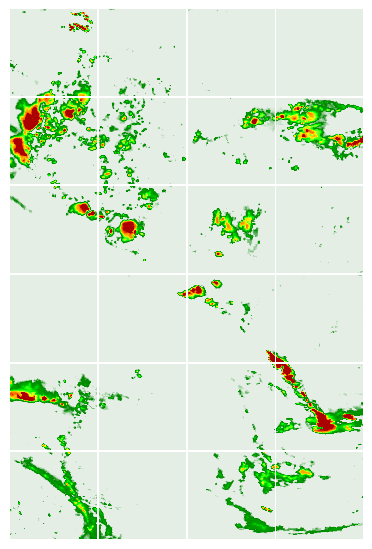

In [24]:
plot_single_patched_imerg_grid(
    patched_imerg_tile=loaded_imerg_tile,
    plot_params=plot_params,
    figsize=(3.83, 5.6),
)

In [25]:
# cyclone YUKA
fn = "/Volumes/external_disk_seal/data/GPM/NRT/IMERG/IMERG-ER/2023/03/09/3B-HHR-E.MS.MRG.3IMERG.20230309-S120000-E122959.0720.V07B.RT-H5"

imerg_tile = load_imerg_h5_file_into_xarr(file_path=fn)
imerg_tile = crop_xarr_using_lat_and_lon(
    xarr=imerg_tile,
    lat_lims=IMERG_CROP["inner"]["latitude"],
    lon_lims=IMERG_CROP["inner"]["longitude"],
)
print(imerg_tile.shape)

# patch the tile.
x_pad = calculate_required_1d_padding(X=imerg_tile.shape[1], Y=PATCH_SIZE, frac=0)
y_pad = calculate_required_1d_padding(X=imerg_tile.shape[0], Y=PATCH_SIZE, frac=0)
print(x_pad, y_pad)

imerg_patches = patch_2d_arr_into_nxn_squares(
    arr2d=imerg_tile,
    n=PATCH_SIZE,
    x_pad=x_pad,
    y_pad=y_pad,
    flip_pixels=True,
    overlap=0,
)

imerg_patches.shape

(768, 512)
0 0


(6, 4, 128, 128)

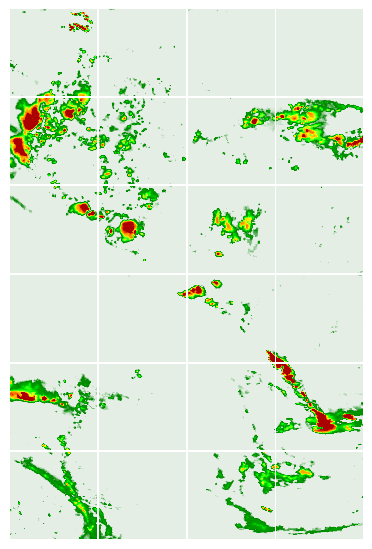

In [26]:
plot_single_patched_imerg_grid(
    patched_imerg_tile=imerg_patches,
    plot_params=plot_params,
    figsize=(3.83, 5.6),
)

In [27]:
assert np.allclose(imerg_patches, loaded_imerg_tile)

### END OF SCRIPT.